In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
%matplotlib inline

from pandas_datareader import data as pdr
yf.pdr_override() # <== that's all it takes :-)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', None)

## Load Data and Create Stock Table

In [2]:
# Load and put stock data to df w pandas_datareader
stock1 = pdr.get_data_yahoo("^DJI", start="1980-01-01", end="1996-02-28")
stock2 = pdr.get_data_yahoo("^DJI", start="2011-01-01", end="2015-02-28")
stock = pd.concat([stock1,stock2])
stock['Date']=stock.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
stock['Date'] = pd.to_datetime(stock.index)

# create yr,month,day cols
stock['year'] = pd.DatetimeIndex(stock['Date']).year
stock['month'] = pd.DatetimeIndex(stock['Date']).month
stock['day'] = pd.DatetimeIndex(stock['Date']).day
stock['CPI_Multiplier_temp'] = 0.0

# reduce stock df
stockr=stock[['Close','year','month','CPI_Multiplier_temp','Date']]

## Adjust for Inflation

In [4]:
# load inflation data
inflation = pd.read_csv('inflation_data.csv')

inflation.rename(columns={'CPIAUCNS':'CPI','DATE':'date'},inplace=True)
# create index multiplier
inflation['CPI_Multiplier'] = inflation['CPI'].iloc[-1] / inflation['CPI']

# create yr,month,day cols
inflation['year'] = pd.DatetimeIndex(inflation['date']).year
inflation['month'] = pd.DatetimeIndex(inflation['date']).month
inflation['day'] = 1
inflation.index=inflation['date']


In [5]:
# Create Matrix With Inflation Adjusted Prices
count=0
for idx_stock, row_stock in stockr.iterrows():
    temp=inflation.loc[(inflation['year'] == int(row_stock['year'])) & (inflation['month'] ==  int(row_stock['month']))]
    stockr['CPI_Multiplier_temp'][count]=temp['CPI_Multiplier'][0]
    count+=1

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
stockr['Inflation_Adjusted_Close']=stockr['Close']*stockr['CPI_Multiplier_temp']

stock_fin=stockr[['Close','CPI_Multiplier_temp','Inflation_Adjusted_Close','Date']]
stock_fin.rename(columns={'CPI_Multiplier_temp':'CPI_Multiplier'},inplace=True)
stock_fin.tail()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Close,CPI_Multiplier,Inflation_Adjusted_Close,Date
Date,,,,
2015-02-23,18116.839844,1.102061,19965.865565,2015-02-23
2015-02-24,18209.189453,1.102061,20067.640483,2015-02-24
2015-02-25,18224.570312,1.102061,20084.591130,2015-02-25
2015-02-26,18214.419922,1.102061,20073.404779,2015-02-26
2015-02-27,18132.699219,1.102061,19983.343566,2015-02-27


In [7]:
#fig1 = plt.figure(figsize=(15,10),dpi=400)
#plt.xlabel('Date')
#plt.ylabel('Price ($)')
#plt.title('DowJones Value')
#plt.plot(stock_fin[['Close']])
#plt.grid(c='grey')
#plt.xticks(rotation=45)


## Visualization

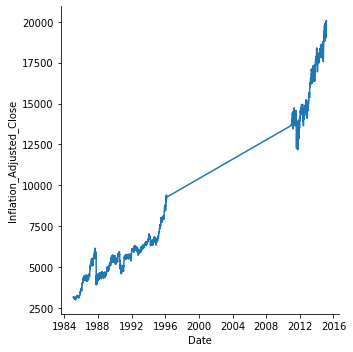

In [8]:
sns.relplot(x='Date',y='Inflation_Adjusted_Close',kind='line',data=stock_fin)

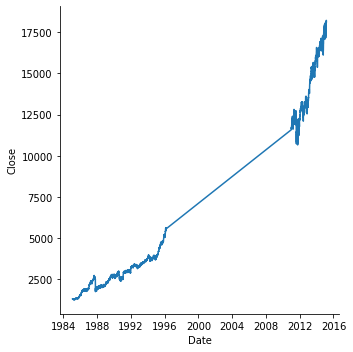

In [9]:
sns.relplot(x='Date',y='Close',kind='line',data=stock_fin)

## Fit ^DJI Data 

In [10]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()

In [11]:
# Convert date to ordinal (devide by 200 to somewhat normalize)
#data_df['Date'] = pd.to_datetime(data_df['Date'])
#data_df['Date']=data_df['Date'].map(dt.datetime.toordinal)

stock_fin['Date_ord']=stock_fin['Date'].map(dt.datetime.toordinal)/200

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
X=stock_fin[['Date_ord']]
Y=stock_fin['Inflation_Adjusted_Close']
f=lm.fit(X,Y)

In [20]:
# Date to Predict 2020
pred_date = pdr.get_data_yahoo("^DJI", start="1980-01-01", end="2020-02-29")
#pred_date['Date']=pred_date.index
pred_date['Date'] = pd.to_datetime(pred_date.index)
pred_date['Date_ord']=pred_date['Date'].map(dt.datetime.toordinal)/200
pred_date=pred_date[['Date_ord']]

#pred_date = pd.DataFrame({'year': [2020,2020],'month': [5,5],'day': [1,2]})
#pred_date = pd.to_datetime(pred_date)
#pred_date = pred_date.map(dt.datetime.toordinal)/200

Yhat=lm.predict(pred_date)

fittedf=stock_fin
fittedf['prediction']=Yhat

#sns.lmplot(x="Date_ord", y='Inflation_Adjusted_Close', data=stock_fin,order=2)


def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = fittedf[['Date_ord']]
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Value ~ Date')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Value')

    plt.show()
    plt.close()
    
x = fittedf['Date_ord']
y = fittedf['Inflation_Adjusted_Close']

# Here we use a polynomial of the 4th order 
f = np.polyfit(x, y, 2)
p = np.poly1d(f)
print(p)

PlotPolly(p, x, y, 'asdfad')

[*********************100%***********************]  1 of 1 completed


ValueError: Length of values does not match length of index

In [14]:
np.polyfit(x, y, 1)

array([ 2.53468650e+02, -9.15442988e+05])

In [16]:
Yhat

array([ 2962.6469285 ,  2963.91427175,  2965.181615  , ...,
       16883.14521221, 16884.41255546, 16885.67989871])